# 3. Find and Classify Cells

In [19]:
from predict import make_pred, post_processing, make_pred_dataframe
from dataset import TNBC2, TNBCWSI
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import config
import pandas as pd
c = config.Config()

In [38]:
tnbc = TNBC2()
model_name = 'unet_quip_10000'
stride = int(c.WIDTH*3/2)

tumor_cells = []
immune_cells = []
sizes = []

n = 1
size_limit = 5
d = []
cutoff = 0.05
#for cutoff in np.arange(0.02, 0.07, 0.001):
for imid in tnbc.ids[:n]:
    path = tnbc.file_name(imid)
    img = tnbc.load_image(imid)
    pred = make_pred(path, model_name, stride, 1.0)
    mask = post_processing(pred, cutoff, size_limit)

    df_pred = make_pred_dataframe(imid, mask, img)
    pred_class = np.zeros_like(mask).astype(np.uint8)
    for _, row in df_pred[df_pred["image_id"] == imid].iterrows():
        obj = row["obj"]
        s = 5
        obj = (slice(obj[0].start-s, obj[0].stop+s, None),
              slice(obj[1].start-s, obj[1].stop+s, None))
        sizes.append(row["mask"].sum())
        if row["class_name"] == "immune cells":
            immune_cells.append(img[obj])
        elif row["class_name"] == "tumor":
            tumor_cells.append(img[obj])
        else:
            print(row["class_name"])
        pred_class[row["obj"]] = (1 + row["class"]) * row["mask"]



    #plt.figure(figsize=(20,20))
    #plt.subplot(121)
    #plt.imshow(img)
    #plt.subplot(122)
    #plt.imshow(pred_class, alpha=1.0)
    d.append(
    {
        "cutoff" : cutoff,
        "n_immune" : df_pred["class_name"].value_counts()["immune cells"],
        "n_tumor" : df_pred["class_name"].value_counts()["tumor"],
    })
df = pd.DataFrame(d)

<ipython-input-39-2d556e7bbe57>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(4,2))


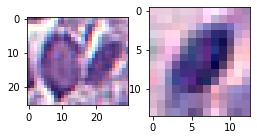

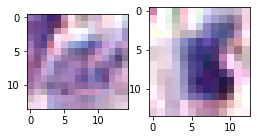

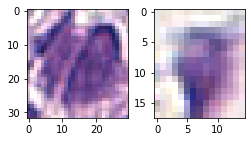

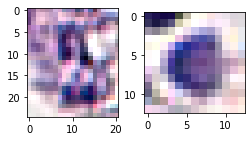

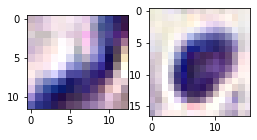

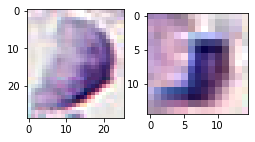

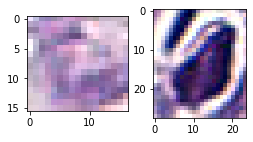

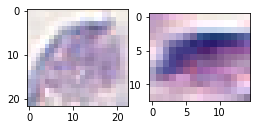

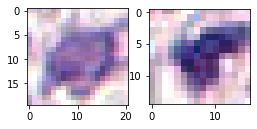

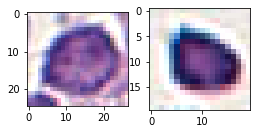

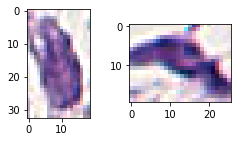

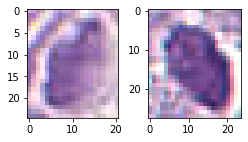

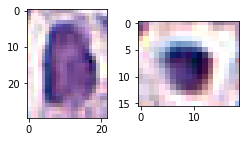

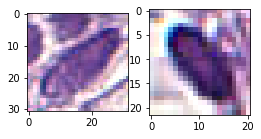

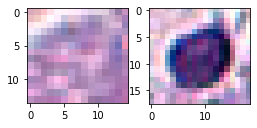

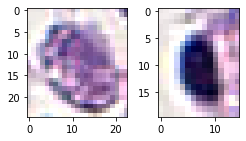

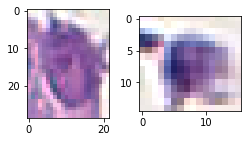

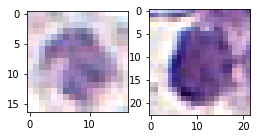

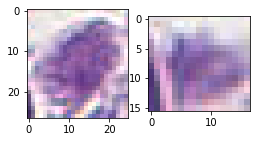

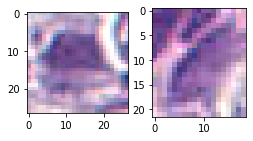

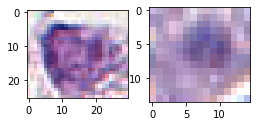

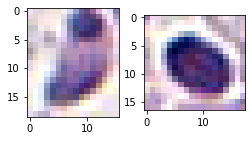

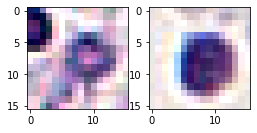

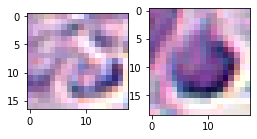

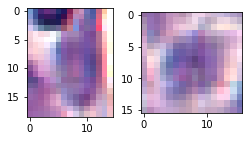

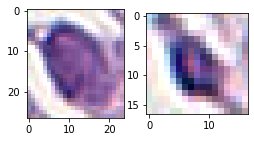

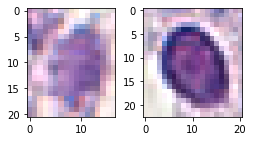

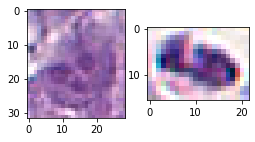

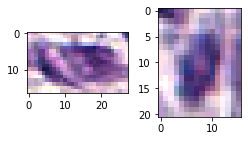

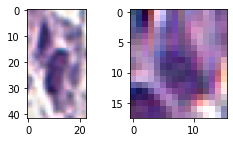

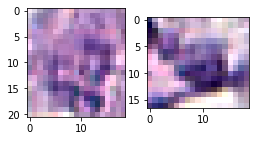

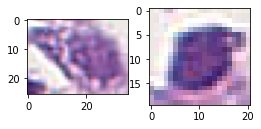

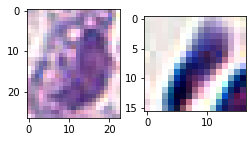

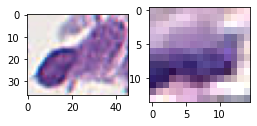

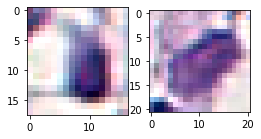

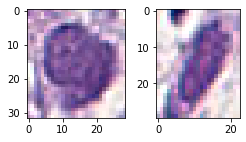

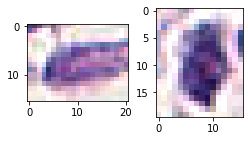

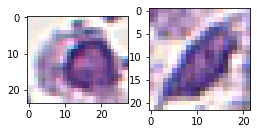

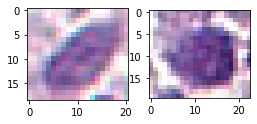

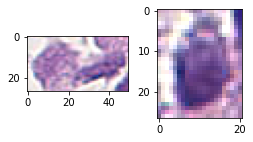

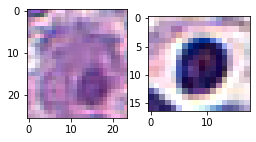

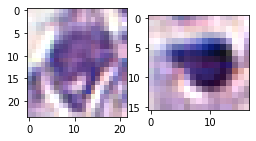

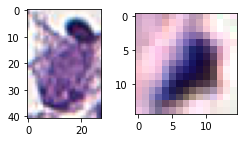

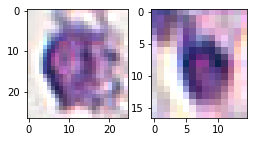

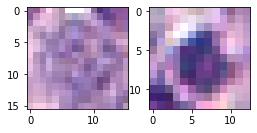

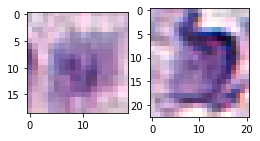

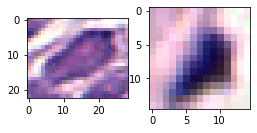

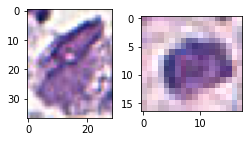

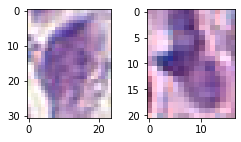

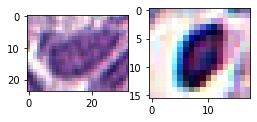

In [39]:
k = 10
for t, i in zip(random.choices(tumor_cells, k=k),
                random.choices(immune_cells, k=k)):
    plt.figure(figsize=(4,2))
    plt.subplot(121)
    plt.imshow(t)
    plt.subplot(122)
    plt.imshow(i)

## Predict and classify all TNBC

In [2]:
import importlib
import dataset
from dataset import TNBC2
from tqdm import tqdm
from predict import predict_path, post_processing, make_pred_dataframe
from predict import make_patient_dataframe
import pandas as pd
#import keras.backend as K
import config
c = config.Config()
importlib.reload(dataset)

tnbc = TNBC2()
cutoff = 0.05
size_limit = 5
model = 'unet_quip_10000'
scale = 1.0
stride = int(3*c.HEIGHT/2)

dfs = []
from time import time
for imid in tqdm(tnbc.ids):
    pred = predict_path(
        tnbc.file_name(imid), 
        model,
        stride,
        scale)
    mask = post_processing(pred, cutoff, size_limit)
    try:
        dfs.append(make_pred_dataframe(imid, mask, tnbc.load_image(imid)))
    except KeyError:
        continue

ImportError: cannot import name 'make_pred' from 'predict' (/tank/data/arvid/SweBCG91RT-Net/notebooks/predict.py)

In [ ]:
import importlib
import dataset
from dataset import TNBCWSI
from tqdm import tqdm
from predict import predict_image, post_processing, make_pred_dataframe
from predict import make_patient_dataframe
import pandas as pd
import keras
#import keras.backend as K
import config
from weighted_loss_unet import *


def iou():
    pass

c = config.Config()

tnbc = TNBCWSI()
cutoff = 0.05
size_limit = 5
model_name = 'unet_quip_10000'
scale = 1.0
stride = int(3*c.HEIGHT/2)
n_samples = 200

model = keras.models.load_model(                                                    
    c.MODEL_DIR / f"unet/{model_name}.h5",                                          
    custom_objects={"my_loss": my_loss, "iou": iou},                       
    compile=False,                               
) 
# Add to leaky code within python_script_being_profiled.py
from pympler import muppy, summary
# Prints out a summary of the large objects
    
df_pat = pd.DataFrame()
for imid in tqdm(tnbc.ids):
    for img in tnbc.patches(imid, n_samples):
        pred = predict_image(img, model, stride)
        mask = post_processing(pred, cutoff, size_limit)
        
        if np.sum(mask):
            try:
                df_cells = make_pred_dataframe(imid, mask, img)
                df_pat = pd.concat([df_pat, make_patient_dataframe(df_cells)])
            except Exception as e:
                print(e)
            #all_objects = muppy.get_objects()
            #sum1 = summary.summarize(all_objects)
            #summary.print_(sum1)
                
df_pat.to_pickle(f'../data/tnbc2/wsi_{model_name}_{cutoff}_{size_limit}_{scale}_{n_samples}.pickle')

  8%|▊         | 22/263 [1:24:13<15:02:03, 224.58s/it]/tank/data/arvid/SweBCG91RT-Net/notebooks/predict.py:42: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.ravel(np.where(im != 0, im, np.nan)))


Input contains NaN, infinity or a value too large for dtype('float64').


 12%|█▏        | 31/263 [1:58:42<14:48:53, 229.89s/it]/tank/data/arvid/SweBCG91RT-Net/notebooks/predict.py:42: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.ravel(np.where(im != 0, im, np.nan)))


Input contains NaN, infinity or a value too large for dtype('float64').


/tank/data/arvid/SweBCG91RT-Net/notebooks/predict.py:42: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.ravel(np.where(im != 0, im, np.nan)))


Input contains NaN, infinity or a value too large for dtype('float64').


/tank/data/arvid/SweBCG91RT-Net/notebooks/predict.py:42: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.ravel(np.where(im != 0, im, np.nan)))


Input contains NaN, infinity or a value too large for dtype('float64').


 16%|█▌        | 41/263 [2:36:40<14:07:01, 228.93s/it]/tank/data/arvid/SweBCG91RT-Net/notebooks/predict.py:42: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.ravel(np.where(im != 0, im, np.nan)))


Input contains NaN, infinity or a value too large for dtype('float64').


/tank/data/arvid/SweBCG91RT-Net/notebooks/predict.py:42: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.ravel(np.where(im != 0, im, np.nan)))


Input contains NaN, infinity or a value too large for dtype('float64').


 18%|█▊        | 47/263 [3:00:29<14:20:45, 239.10s/it]